In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt 
import time

In [10]:
class SVM: #this classifier is based on a form like f(x) = w^Tx + b 
    def __init__(self, C=1, limit=100000):
        self.kernel = lambda x,y: np.matmul(x, y.T)
        self.C = C #penalty associated to when instance is incorrectly classified or violates max margin
        self.limit = limit #iterations that the fit function loops over to minimize the cost function
        
    def fit(self, x, y):
        self.y = (y * 2) - 1 #keeps 1s as 1s and 0s as -1 to follow logic of support vector machine
        self.ws = np.zeros_like(self.y, dtype=float) #these are the alphas that act as weights multiplied with the inner product(kernel) of the input data
        self.x = x.copy() #copy data to not corrupt it in memory
        k = self.kernel(self.x, self.x) * self.y[:,np.newaxis] * self.y #this is the actual form of the x used in the w^Tx + b equation and is a substitute for inner product as the kernel
    
        for _ in range(self.limit): #max times optimization is run
            for i in range(len(self.ws)): #goes through all of the xs so row of data
                j = np.random.randint(0, len(self.ws)) #each itertion gets a random pair value as the other one to compare to
                a = [i, j]
                p = [i, i]
                q = [j, j]
                m = [p, q]
                n = [a, a]
                r = 1 - np.sum(self.ws * k[a], axis=1) #1
                S = k[m, n] #2
                u = self.ws[a] #3
                d = [-self.y[j], self.y[i]] #4
                v = np.array(d) #4
                z = 2 * np.matmul(r, v) / (np.matmul(np.matmul(S, v), v) + 1E-10) #5 the + 1E-10 is to make sure the bottom doesn't accidently round to 0 and turn z into nan
                z = u + v * ((np.clip(u + z*v, 0, self.C) - u)[1]/v[1]) #we want ws bounded by C so things outside get clipped off for both alpha_i and aplha_j hence the two clip lines
                self.ws[a] = u + v * ((np.clip(u + z*v, 0, self.C) - u)[0]/v[0]) #6
    
        idx, = np.nonzero(self.ws)
        self.b = np.mean((1.0 - np.sum(k[idx] * self.ws, axis=1)) * self.y[idx]) #b is threshold used to adhere to KKT mainly used to help predict #7

    def predict(self, x):
        func = lambda x: np.sum(self.kernel(x, self.x) * self.y * self.ws, axis=1) + self.b #decision chooses y = 1 for f(x) > 0 and y = -1 for f(x) < 0 and is 7 without known labels #8
        return np.heaviside(func(x), 1)  #basically gets the sign of decision meaning if its -1 or 1 and then sends it back as the predicted y

<div class="answer">
    
These are the equations used in the Support Vector Machine Algorithm
    

1. $r = (1 - w^T*\alpha_i, 1-w^T*\alpha_j)^2$


2. $
  S = \begin{bmatrix}
    \alpha_{ii} & \alpha_{ij}\\ 
    \alpha_{ji} & \alpha_{jj}
  \end{bmatrix}
$
   

3. $u = (w_i, w_j)^2$
    

4. $v = (-y_i, y_j)^T$

5. $z = \frac{2*r^Tv}{v^TSv}$ which comes from the loss function set to 0

6. $(w_i, w_j)^T = v + z*u$

7. $b = E_k[y_k -  \sum_a w_a*y_a(x_a*x_k) | w_k > 0]$
    
8. $f(x) = \sum_a w_a*y_a(x_a*x) + b$
    
Loss function $L = r^Tv + \frac{1}{2}v^TSv$ to get optimization sets equal to 0, $0 = r^Tv + \frac{1}{2}v^TSv$, making $r^Tv = \frac{1}{2}v^TSv$ so $z = \frac{2r^Tv}{v^TSv}$ 
</div>

In [4]:
startTime = time.time()
df = pd.read_csv("diabetes.csv")
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop=True)  
#df
#creating the folds for k fold cross validation by splitting up data into three
fold1 = df.loc[0:255]                                            
fold2 = df.loc[256:511]
fold3 = df.loc[512:]
train1 = pd.concat([fold1, fold2])
test1 = fold3
trainx1 = np.array(train1[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
trainy1 = np.array(train1["Outcome"])
testx1 = np.array(test1[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
testy1 = np.array(test1["Outcome"])
#clf = SVM(kernel='rbf')
clf = SVM()
clf.fit(trainx1, trainy1)
predy1 = clf.predict(testx1)
#acc1 = np.count_nonzero(testy1 == predy1) / len(testy1)
#print("Accuracy 1:", acc1)
tp = np.sum((testy1 == 1) & (predy1 == 1))
tn = np.sum((testy1 == 0) & (predy1 == 0))
fn = np.sum((testy1 == 1) & (predy1 == 0))
fp = np.sum((testy1 == 0) & (predy1 == 1))
precision = (tp  * 100) / float(tp + fp) / 100
recall = (tp  * 100) / float(tp + fn) / 100
f1 = (2*precision*recall) / (precision + recall)
print("f1 score: ", f1) 
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

f1 score:  0.6091370558375635
Execution time in seconds: 2427.1538445949554


In [3]:
#count = 5 #how many different hyperparameter values we are testing
#default C for SVC is 1 so we will try 0.01 0.1 1 10 100 to see differences
vals = [0.01, 0.1, 1, 10, 100, 1000, 100000, 1000000]
avgs = []
for i in range(len(vals)):
    #reading in and randomizing the dataset
    df = pd.read_csv("diabetes.csv")
    df = df.reindex(np.random.permutation(df.index))
    df = df.reset_index(drop=True)  
    #df
    #creating the folds for k fold cross validation by splitting up data into three
    fold1 = df.loc[0:255]                                            
    fold2 = df.loc[256:511]
    fold3 = df.loc[512:]
    train1 = pd.concat([fold1, fold2])
    test1 = fold3
    trainx1 = np.array(train1[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    trainy1 = np.array(train1["Outcome"])
    testx1 = np.array(test1[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    testy1 = np.array(test1["Outcome"])
    train2 = pd.concat([fold1, fold3])
    test2 = fold2
    trainx2 = np.array(train2[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    trainy2 = np.array(train2["Outcome"])
    testx2 = np.array(test2[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    testy2 = np.array(test2["Outcome"])
    train3 = pd.concat([fold2, fold3])
    test3 = fold1
    trainx3 = np.array(train3[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    trainy3 = np.array(train3["Outcome"])
    testx3 = np.array(test3[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    testy3 = np.array(test3["Outcome"])
    #testing the Accuracy of each fold with one fold left out as test
    clf = SVM(C=vals[i])
    clf.fit(trainx1, trainy1)
    predy1 = clf.predict(testx1)
    tp = np.sum((testy1 == 1) & (predy1 == 1))
    tn = np.sum((testy1 == 0) & (predy1 == 0))
    fn = np.sum((testy1 == 1) & (predy1 == 0))
    fp = np.sum((testy1 == 0) & (predy1 == 1))
    precision = (tp  * 100) / float(tp + fp) / 100
    recall = (tp  * 100) / float(tp + fn) / 100
    f1one = (2*precision*recall) / (precision + recall)
    print("f1 score 1: ", f1one) 
    clf = SVM(C=vals[i])
    clf.fit(trainx2, trainy2)
    predy2 = clf.predict(testx2)
    tp = np.sum((testy2 == 1) & (predy2 == 1))
    tn = np.sum((testy2 == 0) & (predy2 == 0))
    fn = np.sum((testy2 == 1) & (predy2 == 0))
    fp = np.sum((testy2 == 0) & (predy2 == 1))
    precision = (tp  * 100) / float(tp + fp) / 100
    recall = (tp  * 100) / float(tp + fn) / 100
    f1two = (2*precision*recall) / (precision + recall)
    print("f1 score: ", f1two) 
    clf = SVM(C=vals[i])
    clf.fit(trainx3, trainy3)
    predy3 = clf.predict(testx3)
    tp = np.sum((testy3 == 1) & (predy3 == 1))
    tn = np.sum((testy3 == 0) & (predy3 == 0))
    fn = np.sum((testy3 == 1) & (predy3 == 0))
    fp = np.sum((testy3 == 0) & (predy3 == 1))
    precision = (tp  * 100) / float(tp + fp) / 100
    recall = (tp  * 100) / float(tp + fn) / 100
    f1three = (2*precision*recall) / (precision + recall)
    print("f1 score: ", f1three)
    avg = (f1one + f1two + f1three) / 3
    print("Average f1", avg)
    avgs.append([vals[i], avg])
    
print("avgs are: ", avgs) 

f1 score 1:  0.6263736263736264
f1 score:  0.49214659685863876
f1 score:  0.6310160427807486
Average f1 0.5831787553376713
f1 score 1:  0.42162162162162165
f1 score:  0.669683257918552
f1 score:  0.4705882352941177
Average f1 0.5206310382780971
f1 score 1:  0.7035175879396985
f1 score:  0.6494845360824744
f1 score:  0.5921787709497207
Average f1 0.6483936316572979
f1 score 1:  0.6572769953051643
f1 score:  0.44324324324324327
f1 score:  0.5777777777777778
Average f1 0.5594326721087285
f1 score 1:  0.39743589743589747
f1 score:  0.67
f1 score:  0.5494505494505495
Average f1 0.538962148962149
f1 score 1:  0.5964912280701753
f1 score:  0.6185567010309279
f1 score:  0.6851851851851852
Average f1 0.6334110380954295
f1 score 1:  0.6974358974358974
f1 score:  0.6256410256410256
f1 score:  0.5524861878453038
Average f1 0.6251877036407423
f1 score 1:  0.44171779141104295
f1 score:  0.4831460674157303
f1 score:  0.430939226519337
Average f1 0.4519343617820368
avgs are:  [[0.01, 0.583178755337671

In [4]:
#avgs are:  [[0.01, 0.5831787553376713], [0.1, 0.5206310382780971], [1, 0.6483936316572979], [10, 0.5594326721087285], [100, 0.538962148962149], [1000, 0.6334110380954295], [100000, 0.6251877036407423], [1000000, 0.4519343617820368]]
avgs = [[0.01, 0.5831787553376713], [0.1, 0.5206310382780971], [1, 0.6483936316572979], [10, 0.5594326721087285], [100, 0.538962148962149], [1000, 0.6334110380954295], [100000, 0.6251877036407423], [1000000, 0.4519343617820368]]
print(avgs)
avgs = np.array(avgs)
x = avgs[:, 0]
y = avgs[:, 1]
print(x)
print(y)

[[0.01, 0.5831787553376713], [0.1, 0.5206310382780971], [1, 0.6483936316572979], [10, 0.5594326721087285], [100, 0.538962148962149], [1000, 0.6334110380954295], [100000, 0.6251877036407423], [1000000, 0.4519343617820368]]
[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+05 1.e+06]
[0.58317876 0.52063104 0.64839363 0.55943267 0.53896215 0.63341104
 0.6251877  0.45193436]


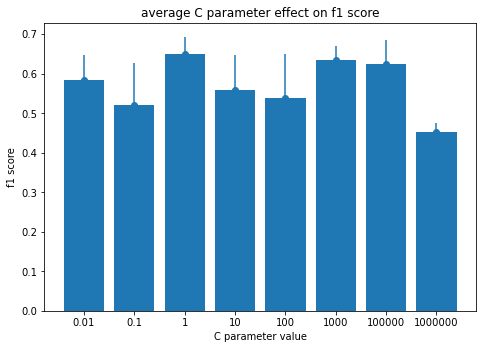

In [8]:
x = ['0.01', '0.1', '1', '10', '100', '1000', '100000', '1000000']
y = [0.5831787553376713, 0.5206310382780971, 0.6483936316572979, 0.5594326721087285, 0.5389621489621494, 0.6334110380954295, 0.6251877036407423, 0.4519343617820368]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#fig = plt.figure(figsize = (10, 5))
#plt.bar(x, y, color ='maroon', width = 0.4)
#langs = ['C', 'C++', 'Java', 'Python', 'PHP']
#students = [23,17,35,29,12]
ax.set_xlabel('C parameter value')
ax.set_ylabel('f1 score')
ax.set_title('average C parameter effect on f1 score')
ax.bar(x, y)
plt.errorbar(x, y, yerr = err, fmt ='o')
plt.show()

In [7]:
one = [0.6263736263736264, 0.49214659685863876, 0.6310160427807486]
two = [0.42162162162162165, 0.669683257918552, 0.4705882352941177]
three = [0.7035175879396985, 0.6494845360824744, 0.5921787709497207]
four = [0.6572769953051643, 0.44324324324324327, 0.5777777777777778]
five = [0.39743589743589747, 0.67, 0.5494505494505495]
six = [0.5964912280701753, 0.6185567010309279, 0.6851851851851852]
seven = [0.6974358974358974, 0.6256410256410256, 0.5524861878453038]
eight = [0.44171779141104295, 0.4831460674157303, 0.430939226519337]
err = [np.std(one), np.std(two), np.std(three), np.std(four), np.std(five), np.std(six), np.std(seven), np.std(eight)]
print(err)

[0.06439735199285783, 0.10727489749376808, 0.04546042672134814, 0.08833654937013108, 0.11152070782369662, 0.0377018390744994, 0.05917633932142312, 0.022504403890563754]


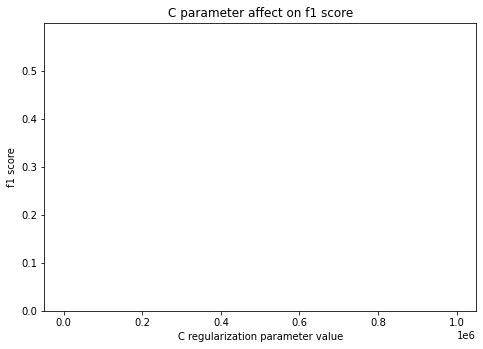

In [10]:
#fig = plt.figure()
#fig = plt.figure(figsize = (10, 5))
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.set_xlabel('C regularization parameter value')
ax.set_ylabel('f1 score')
ax.set_title('C parameter affect on f1 score')
plt.bar(x, y, color ='maroon', width = 0.4)
#langs = ['C', 'C++', 'Java', 'Python', 'PHP']
#students = [23,17,35,29,12]
#ax.bar(x, y)
plt.show()

(array([2., 0., 2., 0., 1., 2., 0., 0., 0., 1.]),
 array([-0.02481856, -0.00329481,  0.01822894,  0.03975269,  0.06127644,
         0.08280019,  0.10432394,  0.1258477 ,  0.14737145,  0.1688952 ,
         0.19041895]),
 <BarContainer object of 10 artists>)

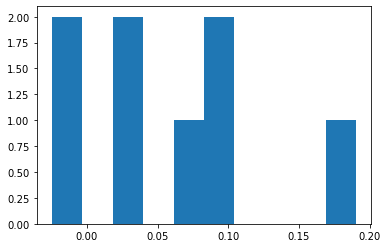

In [6]:
y_m = [0.5831787553376713, 0.5206310382780971, 0.6483936316572979, 0.5594326721087285, 0.5389621489621494, 0.6334110380954295, 0.6251877036407423, 0.4519343617820368]
y_s = [0.61640066, 0.60853735, 0.62357507, 0.63126092, 0.62292755, 0.62073473, 0.64779067, 0.64235331]
y_m = np.array(y_m)
y_s = np.array(y_s)
y_diff = y_s - y_m
plt.hist(y_diff)

In [9]:
y_diff
x = ['0.01', '0.1', '1', '10', '100', '1000', '100000', '1000000']
print(y_diff)


[ 0.0332219   0.08790631 -0.02481856  0.07182825  0.0839654  -0.01267631
  0.02260297  0.19041895]


<BarContainer object of 8 artists>

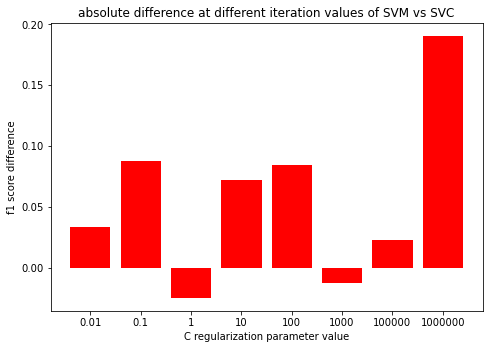

In [7]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.set_xlabel('C regularization parameter value')
ax.set_ylabel('f1 score difference')
ax.set_title('absolute difference at different iteration values of SVM vs SVC')
plt.bar(x, y_diff, color='red')

In [12]:
#default max_iter for SVC is -1 which is no limit but that is a problem because we can not compare it with the tolerance used to a scratch implementation
#Therefore we will use 7 different values for max_iter to test, 1, 10, 100, 1000, 10000, 100000, 1000000
vals = [1, 10, 100, 1000, 10000, 100000, 1000000]
avgs = []
for i in range(len(vals)):
    #reading in and randomizing the dataset
    df = pd.read_csv("diabetes.csv")
    df = df.reindex(np.random.permutation(df.index))
    df = df.reset_index(drop=True)  
    #df
    #creating the folds for k fold cross validation by splitting up data into three
    fold1 = df.loc[0:255]                                            
    fold2 = df.loc[256:511]
    fold3 = df.loc[512:]
    train1 = pd.concat([fold1, fold2])
    test1 = fold3
    trainx1 = np.array(train1[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    trainy1 = np.array(train1["Outcome"])
    testx1 = np.array(test1[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    testy1 = np.array(test1["Outcome"])
    train2 = pd.concat([fold1, fold3])
    test2 = fold2
    trainx2 = np.array(train2[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    trainy2 = np.array(train2["Outcome"])
    testx2 = np.array(test2[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    testy2 = np.array(test2["Outcome"])
    train3 = pd.concat([fold2, fold3])
    test3 = fold1
    trainx3 = np.array(train3[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    trainy3 = np.array(train3["Outcome"])
    testx3 = np.array(test3[["Pregnancies", "Glucose", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]])
    testy3 = np.array(test3["Outcome"])
    #testing the Accuracy of each fold with one fold left out as test
    clf = SVM(limit=vals[i])
    clf.fit(trainx1, trainy1)
    predy1 = clf.predict(testx1)
    tp = np.sum((testy1 == 1) & (predy1 == 1))
    tn = np.sum((testy1 == 0) & (predy1 == 0))
    fn = np.sum((testy1 == 1) & (predy1 == 0))
    fp = np.sum((testy1 == 0) & (predy1 == 1))
    precision = (tp  * 100) / float(tp + fp) / 100
    recall = (tp  * 100) / float(tp + fn) / 100
    f1one = (2*precision*recall) / (precision + recall)
    print("f1 score 1: ", f1one) 
    clf = SVM(limit=vals[i])
    clf.fit(trainx2, trainy2)
    predy2 = clf.predict(testx2)
    tp = np.sum((testy2 == 1) & (predy2 == 1))
    tn = np.sum((testy2 == 0) & (predy2 == 0))
    fn = np.sum((testy2 == 1) & (predy2 == 0))
    fp = np.sum((testy2 == 0) & (predy2 == 1))
    precision = (tp  * 100) / float(tp + fp) / 100
    recall = (tp  * 100) / float(tp + fn) / 100
    f1two = (2*precision*recall) / (precision + recall)
    print("f1 score: ", f1two) 
    clf = SVM(limit=vals[i])
    clf.fit(trainx3, trainy3)
    predy3 = clf.predict(testx3)
    tp = np.sum((testy3 == 1) & (predy3 == 1))
    tn = np.sum((testy3 == 0) & (predy3 == 0))
    fn = np.sum((testy3 == 1) & (predy3 == 0))
    fp = np.sum((testy3 == 0) & (predy3 == 1))
    precision = (tp  * 100) / float(tp + fp) / 100
    recall = (tp  * 100) / float(tp + fn) / 100
    f1three = (2*precision*recall) / (precision + recall)
    print("f1 score: ", f1three)
    avg = (f1one + f1two + f1three) / 3
    print("Average f1", avg)
    avgs.append([vals[i], avg])
    
print("avgs are: ", avgs) 

f1 score 1:  0.5398773006134969
f1 score:  0.41379310344827586
f1 score:  0.5056179775280899
Average f1 0.4864294605299542
f1 score 1:  0.382716049382716
f1 score:  0.6069651741293532
f1 score:  0.5363128491620112
Average f1 0.5086646908913601
f1 score 1:  0.379746835443038
f1 score:  0.48888888888888893
f1 score:  0.4640883977900552
Average f1 0.4442413740406607
f1 score 1:  0.40243902439024387
f1 score:  0.4431137724550898
f1 score:  0.5054945054945055
Average f1 0.45034910077994644
f1 score 1:  0.648936170212766
f1 score:  0.5730994152046784
f1 score:  0.47619047619047616
Average f1 0.5660753538693069
f1 score 1:  0.6171428571428572
f1 score:  0.6413043478260869
f1 score:  0.44047619047619047
Average f1 0.5663077984817115


C:\Users\huntm\AppData\Local\Temp\ipykernel_16132\1585163770.py:26: RuntimeWarning: overflow encountered in double_scalars
  z = 2 * np.matmul(r, v) / (np.matmul(np.matmul(S, v), v) + 1E-10) #5 the + 1E-10 is to make sure the bottom doesn't accidently round to 0 and turn z into nan
C:\Users\huntm\AppData\Local\Temp\ipykernel_16132\1585163770.py:21: RuntimeWarning: overflow encountered in multiply
  r = 1 - np.sum(self.ws * k[a], axis=1) #1
C:\Users\huntm\AppData\Local\Temp\ipykernel_16132\1585163770.py:26: RuntimeWarning: invalid value encountered in matmul
  z = 2 * np.matmul(r, v) / (np.matmul(np.matmul(S, v), v) + 1E-10) #5 the + 1E-10 is to make sure the bottom doesn't accidently round to 0 and turn z into nan
C:\Users\huntm\AppData\Local\Temp\ipykernel_16132\1281216548.py:41: RuntimeWarning: invalid value encountered in true_divide
  precision = (tp  * 100) / float(tp + fp) / 100
C:\Users\huntm\AppData\Local\Temp\ipykernel_16132\1281216548.py:42: RuntimeWarning: invalid value enco

f1 score 1:  nan


KeyboardInterrupt: 

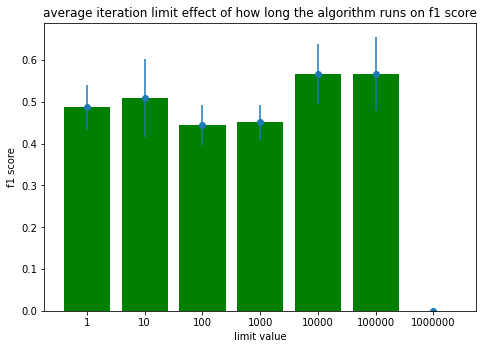

In [6]:
x = ['1', '10', '100', '1000', '10000', '100000', '1000000']
y = [0.4864294605299542, 0.5086646908913601, 0.4442413740406607, 0.45034910077994644, 0.5660753538693069, 0.5663077984817115, 0]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#fig = plt.figure(figsize = (10, 5))
#plt.bar(x, y, color ='maroon', width = 0.4)
#langs = ['C', 'C++', 'Java', 'Python', 'PHP']
#students = [23,17,35,29,12]
ax.set_xlabel('limit value')
ax.set_ylabel('f1 score')
ax.set_title('average iteration limit effect of how long the algorithm runs on f1 score')
ax.bar(x, y, color='green')
plt.errorbar(x, y, yerr = err, fmt ='o')
plt.show()

In [5]:
one = [0.5398773006134969, 0.41379310344827586, 0.5056179775280899]
two = [0.382716049382716, 0.6069651741293532, 0.5363128491620112]
three = [0.379746835443038, 0.48888888888888893, 0.4640883977900552]
four = [0.40243902439024387, 0.4431137724550898, 0.5054945054945055]
five = [0.648936170212766, 0.5730994152046784, 0.47619047619047616]
six = [0.6171428571428572, 0.6413043478260869, 0.44047619047619047]
err = [np.std(one), np.std(two), np.std(three), np.std(four), np.std(five), np.std(six), 0]
print(err)

[0.05323191763181429, 0.09361350678624479, 0.046714917113458994, 0.042382154486560804, 0.07069781599192881, 0.08952146702681722, 0]


(array([1., 3., 1., 0., 1., 0., 0., 0., 0., 1.]),
 array([-0.21601351, -0.13410411, -0.05219471,  0.02971469,  0.11162408,
         0.19353348,  0.27544288,  0.35735228,  0.43926168,  0.52117108,
         0.60308047]),
 <BarContainer object of 10 artists>)

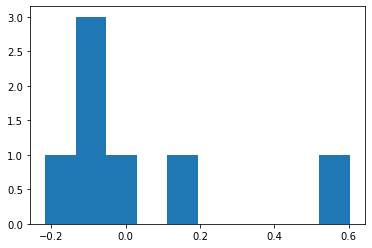

In [14]:
y_m = [0.4864294605299542, 0.5086646908913601, 0.4442413740406607, 0.45034910077994644, 0.5660753538693069, 0.5663077984817115, 0]
y_s = [0.38233458784099694, 0.5314127547427647, 0.5738456337934196, 0.3724135336612265, 0.350061843750248, 0.47394752886224234,  0.6030804745949634]
y_m = np.array(y_m)
y_s = np.array(y_s)
y_diff = y_s - y_m
plt.hist(y_diff)

<BarContainer object of 7 artists>

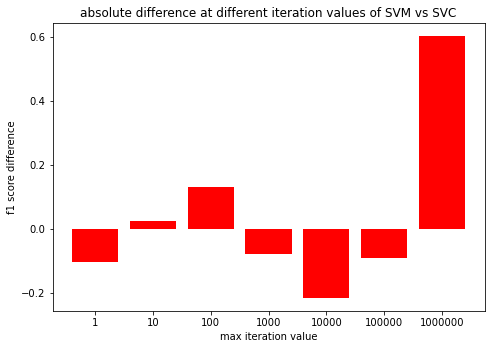

In [16]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.set_xlabel('max iteration value')
ax.set_ylabel('f1 score difference')
ax.set_title('absolute difference at different iteration values of SVM vs SVC')
plt.bar(x, y_diff, color='red')

In [3]:
C_vals = [0.5831787553376713, 0.5206310382780971, 0.6483936316572979, 0.5594326721087285, 0.5389621489621494, 0.6334110380954295, 0.6251877036407423, 0.4519343617820368]
iter_vals = [0.4864294605299542, 0.5086646908913601, 0.4442413740406607, 0.45034910077994644, 0.5660753538693069, 0.5663077984817115, 0]
C_std_dev = np.std(C_vals)
print(C_std_dev)
iter_std_dev = np.std(iter_vals)
print(iter_std_dev)

0.0620861592800763
0.18203799981434246
